In [13]:
!git clone https://github.com/cipher982/marketing-mix-modeling.git
!cp marketing-mix-modeling/funcs.py funcs.py

Cloning into 'marketing-mix-modeling'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 28 (delta 7), reused 20 (delta 3), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [15]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import sys
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
# get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae

sns.color_palette("husl")
sns.set_style('darkgrid')

import pystan
import os
import json
import funcs

%load_ext autoreload

%autoreload 2

In [33]:
!sudo rm -rf mixed-media-marketing

In [16]:
DATA_DIR = 'marketing-mix-modeling/data/'

In [22]:
# Load measured data
m_df = pd.read_csv(DATA_DIR+"measured_ad_channel_data.csv")
m_df = m_df[m_df["channel"] != "Congrats  YOU FOUND ME!!!!"]

# extract weekly dates
m_df = funcs.add_week_start(m_df, 'day')

# get weekly media impressions
m_imp = m_df.groupby(["wk_strt_dt","channel"]).sum()['impressions'].reset_index()
m_imp = m_imp.pivot(index='wk_strt_dt', columns=['channel'], values=['impressions'])
m_imp = m_imp.droplevel(axis=1, level=0).reset_index()
m_imp = m_imp.fillna(value=0)
#m_imp.head(3)

# get weekly media spend
m_sp = m_df.groupby(["wk_strt_dt","channel"]).sum()['spend'].reset_index()
m_sp = m_sp.pivot(index='wk_strt_dt', columns=['channel'], values=['spend'])
m_sp = m_sp.droplevel(axis=1, level=0).reset_index()
m_sp = m_sp.fillna(value=0)
#m_sp.head(3)

# Get weekly sales
sales = pd.read_csv(DATA_DIR+"order_data.csv.gzip", compression="gzip")
sales['date'] = pd.to_datetime(sales['ORDER_DATE'])
sales['weekday'] = sales['date'].dt.weekday
sales["wk_strt_dt"] = sales['date'] - sales['weekday'] * timedelta(days=1)
sales = pd.DataFrame(sales.groupby(["wk_strt_dt"]).sum()['PRODUCT_SUBTOTAL'])
sales.columns = ['sales']

# Get Facebook data
fb = pd.read_csv(DATA_DIR+"collaborative_ad_data.csv")
fb = funcs.add_week_start(fb, "DATE")
fb = pd.DataFrame(fb.groupby(["wk_strt_dt"])['SPEND','IMPRESSIONS'].sum())
fb.columns = ['Facebook_spnd','Facebook_imps']

# Get TV data
tv = pd.read_csv(DATA_DIR+"tv_spend.csv")
tv.fillna(0, inplace=True)
tv = funcs.add_week_start(tv, 'date')
tv['tv_imps'] = tv['spend'] / tv['cost per view']
tv = pd.DataFrame(tv.groupby(['wk_strt_dt'])['tv_imps','spend'].sum())
tv.columns = ['tv_imps', 'tv_spnd']

# Create holiday data
dr = pd.date_range(start=sales.index.min(), end=sales.index.max())
hldy_df = pd.DataFrame()
hldy_df['date'] = dr

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
hldy_df['holiday'] = hldy_df['date'].isin(holidays)

hldy_df = funcs.add_week_start(hldy_df, 'date')
hldy_df = pd.DataFrame(hldy_df.groupby(["wk_strt_dt"]).any()['holiday'])
hldy_df = hldy_df.astype(int)
print("Loaded all datasets.")

Loaded all datasets.


In [2]:
#plt.plot(df['sales'][80:])

In [3]:
#df[['wk_strt_dt','sales']]

In [23]:
# Merge all data
df = pd.merge(m_imp, m_sp, on='wk_strt_dt', suffixes=('_imps','_spnd'))
df = pd.merge(df, hldy_df, left_on='wk_strt_dt', right_index=True)
df = pd.merge(df, sales, left_on='wk_strt_dt', right_index=True)
df = pd.merge(df, fb, left_on='wk_strt_dt', right_index=True)
df = pd.merge(df, tv, left_on='wk_strt_dt', right_index=True, how='left')

# set placeholder for seasonality
df['seasonality'] = 1.0 

# ensure no 0s in the data (bugs like them)
df.fillna(value=0.0, inplace=True)
df = df.replace(to_replace=0.0, value=1.0) 

# mean-centralize: sales, numeric base_vars
hldy_cols = ['holiday']
seas_cols = ['seasonality']
me_cols = []
st_cols = []
mrkdn_cols = []

df_ctrl, sc_ctrl = funcs.mean_center_transform(df, ['sales']+me_cols+st_cols+mrkdn_cols)
df_ctrl = pd.concat([df_ctrl, df[hldy_cols+seas_cols]], axis=1)

# variables positively related to sales: macro economy, store count, markdown, holiday
pos_vars = ['holiday']
X1 = df_ctrl[pos_vars].values

# variables may have either positive or negtive impact on sales: seasonality
pn_vars = [seas_cols[0]]
X2 = df_ctrl[pn_vars].values

In [62]:
hm['Affiliate_imps']

158.0

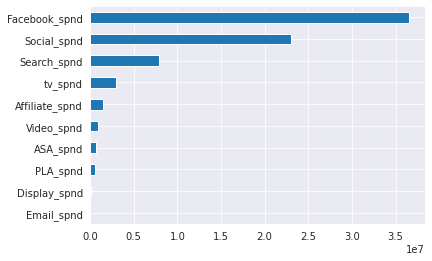

In [68]:
hm = df[[col for col in df.columns if '_spnd' in col]].sum()
hm.sort_values(ascending=True).plot.barh()

In [24]:
ctrl_data = {
    'N': len(df_ctrl),
    'K1': len(pos_vars), 
    'K2': len(pn_vars), 
    'X1': X1,
    'X2': X2, 
    'y': df_ctrl['sales'].values,
    'max_intercept': min(df_ctrl['sales'])
}

ctrl_code1 = '''
data {
  int N; // number of observations
  int K1; // number of positive predictors
  int K2; // number of positive/negative predictors
  real max_intercept; // restrict the intercept to be less than the minimum y
  matrix[N, K1] X1;
  matrix[N, K2] X2;
  vector[N] y; 
}

parameters {
  vector<lower=0>[K1] beta1; // regression coefficients for X1 (positive)
  vector[K2] beta2; // regression coefficients for X2
  real<lower=0, upper=max_intercept> alpha; // intercept
  real<lower=0> noise_var; // residual variance
}

model {
  // Define the priors
  beta1 ~ normal(0, 1); 
  beta2 ~ normal(0, 1); 
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  // The likelihood
  y ~ normal(X1*beta1 + X2*beta2 + alpha, sqrt(noise_var));
}
'''
try:
    sm1
except NameError:
    sm1 = pystan.StanModel(model_code=ctrl_code1, verbose=True)

fit1 = sm1.sampling(data=ctrl_data, iter=2000, chains=4)
fit1_result = fit1.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_548939bc33801f8115bc26206558c913 NOW.
INFO:pystan:OS: linux, Python: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0], Cython 0.29.23


Compiling /tmp/pystan_6rzxq4ft/stanfit4anon_model_548939bc33801f8115bc26206558c913_2390651445376176954.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_6rzxq4ft/stanfit4anon_model_548939bc33801f8115bc26206558c913_2390651445376176954.pyx
building 'stanfit4anon_model_548939bc33801f8115bc26206558c913_2390651445376176954' extension
creating /tmp/pystan_6rzxq4ft/tmp
creating /tmp/pystan_6rzxq4ft/tmp/pystan_6rzxq4ft
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_6rzxq4ft -I/usr/local/lib/python3.7/dist-packages/pystan -I/usr/local/lib/python3.7/dist-packages/pystan/stan/src -I/us

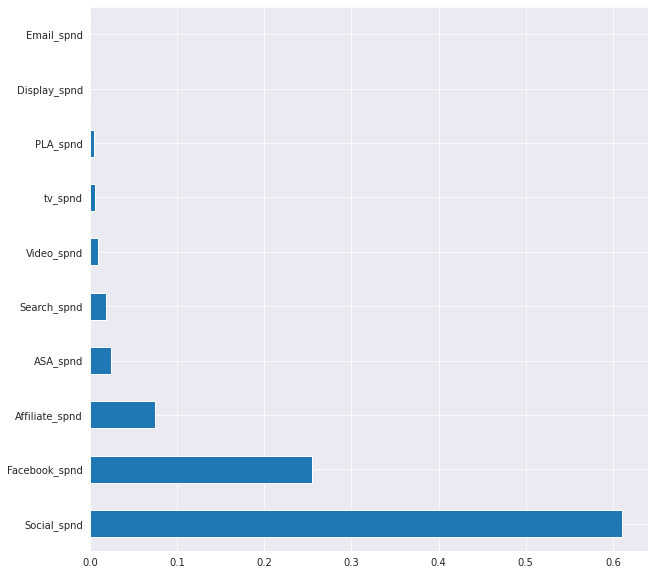

In [71]:
sp_cols = [col for col in df.columns if '_spnd' in col]
spend_df = df[sp_cols + ['sales']]

# Setting X and y variables
X = spend_df.loc[:, spend_df.columns != 'sales']
y = spend_df['sales']
# Building Random Forest model

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=.25, 
    random_state=0
)
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
# Visualizing Feature Importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

In [26]:
# extract control model parameters and predict base sales -> df['base_sales']
def extract_ctrl_model(fit_result, pos_vars=pos_vars, pn_vars=pn_vars, 
                       extract_param_list=False):
    ctrl_model = {}
    ctrl_model['pos_vars'] = pos_vars
    ctrl_model['pn_vars'] = pn_vars
    ctrl_model['beta1'] = fit_result['beta1'].mean(axis=0).tolist()
    ctrl_model['beta2'] = fit_result['beta2'].mean(axis=0).tolist()
    ctrl_model['alpha'] = fit_result['alpha'].mean()
    if extract_param_list:
        ctrl_model['beta1_list'] = fit_result['beta1'].tolist()
        ctrl_model['beta2_list'] = fit_result['beta2'].tolist()
        ctrl_model['alpha_list'] = fit_result['alpha'].tolist()
    return ctrl_model

def ctrl_model_predict(ctrl_model, df):
    pos_vars, pn_vars = ctrl_model['pos_vars'], ctrl_model['pn_vars'] 
    X1, X2 = df[pos_vars], df[pn_vars]
    beta1, beta2 = np.array(ctrl_model['beta1']), np.array(ctrl_model['beta2'])
    alpha = ctrl_model['alpha']
    y_pred = np.dot(X1, beta1) + np.dot(X2, beta2) + alpha
    return y_pred

base_sales_model = extract_ctrl_model(fit1_result, pos_vars=pos_vars, pn_vars=pn_vars)
base_sales = ctrl_model_predict(base_sales_model, df_ctrl)
df['base_sales'] = base_sales*sc_ctrl['sales']
# evaluate control model
print('mape: ', funcs.mean_absolute_percentage_error(df['sales'], df['base_sales']))

# np.savetxt("base_sales_pred.csv", df['base_sales'].values, delimiter=",")
# save_json(base_sales_model, 'ctrl_model.json')
# df['base_sales'] = pd.read_csv('base_sales_pred.csv', header=None).values

mape:  128.28692049122154


In [27]:
# 2.2 Marketing Mix Model
mdip_cols = [col for col in df.columns if '_imp' in col]
mdip_cols

df_mmm, sc_mmm = funcs.mean_log1p_trandform(df, ['sales', 'base_sales'])
mu_mdip = df[mdip_cols].apply(np.mean, axis=0).values
mu_mdip[1] = 100
max_lag = 4
num_media = len(mdip_cols)
# padding zero * (max_lag-1) rows
X_media = np.concatenate((np.zeros((max_lag-1, num_media)), df[mdip_cols].values), axis=0)
X_media = np.nan_to_num(X_media)
X_ctrl = df_mmm['base_sales'].values.reshape(len(df),1)
model_data2 = {
    'N': len(df),
    'max_lag': max_lag, 
    'num_media': num_media,
    'X_media': X_media, 
    'mu_mdip': mu_mdip,
    'num_ctrl': X_ctrl.shape[1],
    'X_ctrl': X_ctrl, 
    'y': df_mmm['sales'].values
}

model_code2 = '''
functions {
  // the adstock transformation with a vector of weights
  real Adstock(vector t, row_vector weights) {
    return dot_product(t, weights) / sum(weights);
  }
}
data {
  // the total number of observations
  int<lower=1> N;
  // the vector of sales
  real y[N];
  // the maximum duration of lag effect, in weeks
  int<lower=1> max_lag;
  // the number of media channels
  int<lower=1> num_media;
  // matrix of media variables
  matrix[N+max_lag-1, num_media] X_media;
  // vector of media variables' mean
  real mu_mdip[num_media];
  // the number of other control variables
  int<lower=1> num_ctrl;
  // a matrix of control variables
  matrix[N, num_ctrl] X_ctrl;
}
parameters {
  // residual variance
  real<lower=0> noise_var;
  // the intercept
  real tau;
  // the coefficients for media variables and base sales
  vector<lower=0>[num_media+num_ctrl] beta;
  // the decay and peak parameter for the adstock transformation of
  // each media
  vector<lower=0,upper=1>[num_media] decay;
  vector<lower=0,upper=ceil(max_lag/2)>[num_media] peak;
}
transformed parameters {
  // the cumulative media effect after adstock
  real cum_effect;
  // matrix of media variables after adstock
  matrix[N, num_media] X_media_adstocked;
  // matrix of all predictors
  matrix[N, num_media+num_ctrl] X;
  
  // adstock, mean-center, log1p transformation
  row_vector[max_lag] lag_weights;
  for (nn in 1:N) {
    for (media in 1 : num_media) {
      for (lag in 1 : max_lag) {
        lag_weights[max_lag-lag+1] <- pow(decay[media], (lag - 1 - peak[media]) ^ 2);
      }
     cum_effect <- Adstock(sub_col(X_media, nn, media, max_lag), lag_weights);
     X_media_adstocked[nn, media] <- log1p(cum_effect/mu_mdip[media]);
    }
  X <- append_col(X_media_adstocked, X_ctrl);
  } 
}
model {
  decay ~ beta(3,3);
  peak ~ uniform(0, ceil(max_lag/2));
  tau ~ normal(0, 5);
  for (i in 1 : num_media+num_ctrl) {
    beta[i] ~ normal(0, 1);
  }
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  y ~ normal(tau + X * beta, sqrt(noise_var));
}
'''
print("Loading StanModel. . .")
try:
    sm2
except NameError:
    sm2 = pystan.StanModel(model_code=model_code2, verbose=True)
#sm2 = pystan.StanModel(model_code=model_code2, verbose=True)
print("Beginning sampling. . .")
fit2 = sm2.sampling(data=model_data2, iter=1000, chains=3)
fit2_result = fit2.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c6677ffefdee0513f144508ee1783d0c NOW.
INFO:pystan:OS: linux, Python: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0], Cython 0.29.23


Loading StanModel. . .
Compiling /tmp/pystan_8fs_gbv5/stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_8077595872953191106.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_8fs_gbv5/stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_8077595872953191106.pyx
building 'stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_8077595872953191106' extension
creating /tmp/pystan_8fs_gbv5/tmp
creating /tmp/pystan_8fs_gbv5/tmp/pystan_8fs_gbv5
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_8fs_gbv5 -I/usr/local/lib/python3.7/dist-packages/pystan -I/usr/local/lib/python3.7/dist-package

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


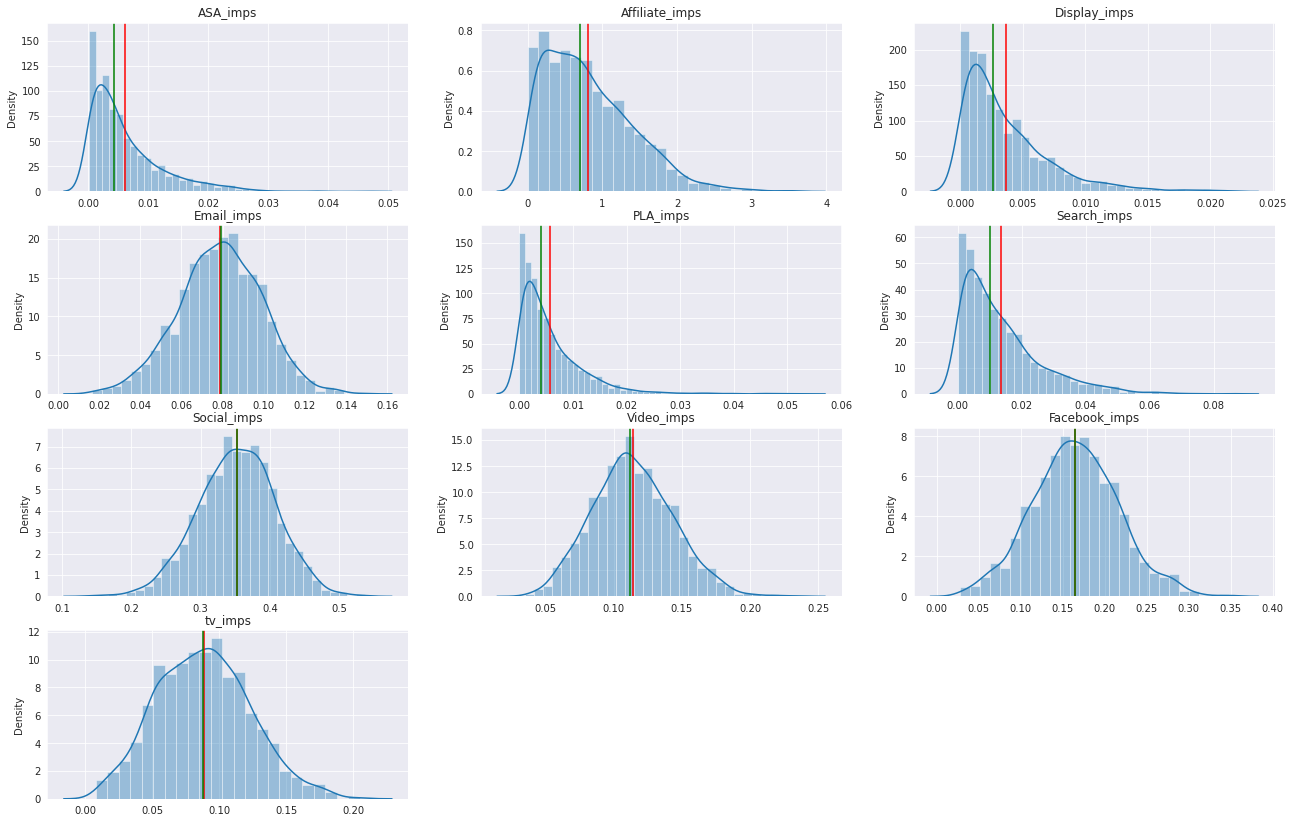

In [38]:
mmm = funcs.extract_mmm(
    fit2, 
    max_lag=max_lag, 
    media_vars=mdip_cols, 
    ctrl_vars=['base_sales']
)

# save_json(mmm, 'mmm1.json')
# plot media coefficients' distributions
# red line: mean, green line: median
beta_media = {}
for i in range(len(mmm['media_vars'])):
    md = mmm['media_vars'][i]
    betas = []
    for j in range(len(mmm['beta_list'])):
        betas.append(mmm['beta_list'][j][i])
    beta_media[md] = np.array(betas)

f = plt.figure(figsize=(22,18))
for i in range(len(mmm['media_vars'])):
    ax = f.add_subplot(5,3,i+1)
    md = mmm['media_vars'][i]
    x = beta_media[md]
    mean_x = x.mean()
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-')
    ax.axvline(median_x, color='g', linestyle='-')
    ax.set_title(md)

In [29]:
# decompose sales to media contribution
mc_df = funcs.mmm_decompose_contrib(mmm, df, original_sales=df['sales'])
adstock_params = mmm['adstock_params']

# calculate media contribution percentage
mc_pct, mc_pct2 = funcs.calc_media_contrib_pct(mc_df, mdip_cols, 'sales', period=52)

# mc_df.to_csv('mc_df1.csv', index=False)
# save_json(adstock_params, 'adstock_params1.json')
# pd.concat([
#     pd.DataFrame.from_dict(mc_pct, orient='index', columns=['mc_pct']),
#     pd.DataFrame.from_dict(mc_pct2, orient='index', columns=['mc_pct2'])
# ], axis=1).to_csv('mc_pct_df1.csv')

rmse (log-log model):  0.5781757078650333
mape (multiplicative model):  106.558533720762


In [30]:
model_code3 = '''
functions {
  // the Hill function
  real Hill(real t, real ec, real slope) {
  return 1 / (1 + (t / ec)^(-slope));
  }
}

data {
  // the total number of observations
  int<lower=1> N;
  // y: vector of media contribution
  vector[N] y;
  // X: vector of adstocked media spending
  vector[N] X;
}

parameters {
  // residual variance
  real<lower=0> noise_var;
  // regression coefficient
  real<lower=0> beta_hill;
  // ec50 and slope for Hill function of the media
  real<lower=0,upper=1> ec;
  real<lower=0> slope;
}

transformed parameters {
  // a vector of the mean response
  vector[N] mu;
  for (i in 1:N) {
    mu[i] <- beta_hill * Hill(X[i], ec, slope);
  }
}

model {
  slope ~ gamma(3, 1);
  ec ~ beta(2, 2);
  beta_hill ~ normal(0, 1);
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01); 
  y ~ normal(mu, sqrt(noise_var));
}
'''


In [31]:
# train hill models for all media channels
try:
    sm3
except NameError:
    sm3 = pystan.StanModel(model_code=model_code3, verbose=True)
sm3 = pystan.StanModel(model_code=model_code3, verbose=True)
hill_models = {}
#to_train = ['dm', 'inst', 'nsp', 'auddig', 'audtr', 'vidtr', 'viddig', 'so', 'on', 'sem']
to_train = ['ASA', 'Affiliate', 'Display', 'Email', 'PLA', 
            'Search', 'Social', 'Video', 'Facebook', 'tv']
for media in to_train:
    print('training for media: ', media)
    hill_model = funcs.train_hill_model(df, mc_df, adstock_params, media, sm3)
    print("trained for media: ", media)
    hill_models[media] = hill_model

# extract params by mean
hill_model_params_mean, hill_model_params_med = {}, {}
for md in list(hill_models.keys()):
    print("extracting " + md)
    hill_model = hill_models[md]
    params1 = funcs.extract_hill_model_params(hill_model, method='mean')
    params1['sc'] = hill_model['sc']
    hill_model_params_mean[md] = params1
#     params2 = extract_hill_model_params(hill_model, method='median')
#     params2['sc'] = hill_model['sc']
#     hill_model_params_med[md] = params2
# save_json(hill_model_params_med, 'hill_model_params_med.json')
# save_json(hill_model_params_mean, 'hill_model_params_mean.json')

# evaluate model params extracted by mean
for md in list(hill_models.keys()):
    print('evaluating media: ', md)
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    _ = funcs.evaluate_hill_model(hill_model, hill_model_params)
# evaluate model params extracted by median
# for md in list(hill_models.keys()):
#     print('evaluating media: ', md)
#     hill_model = hill_models[md]
#     hill_model_params = hill_model_params_med[md]
#     _ = evaluate_hill_model(hill_model, hill_model_params)



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a4112ee77501d9c967031faa602df9b9 NOW.
INFO:pystan:OS: linux, Python: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0], Cython 0.29.23


Compiling /tmp/pystan_l1n9954c/stanfit4anon_model_a4112ee77501d9c967031faa602df9b9_8504363772844590069.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_l1n9954c/stanfit4anon_model_a4112ee77501d9c967031faa602df9b9_8504363772844590069.pyx
building 'stanfit4anon_model_a4112ee77501d9c967031faa602df9b9_8504363772844590069' extension
creating /tmp/pystan_l1n9954c/tmp
creating /tmp/pystan_l1n9954c/tmp/pystan_l1n9954c
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_l1n9954c -I/usr/local/lib/python3.7/dist-packages/pystan -I/usr/local/lib/python3.7/dist-packages/pystan/stan/src -I/us

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a4112ee77501d9c967031faa602df9b9 NOW.
INFO:pystan:OS: linux, Python: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0], Cython 0.29.23


Compiling /tmp/pystan_tamf_3sm/stanfit4anon_model_a4112ee77501d9c967031faa602df9b9_5481519240292296680.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_tamf_3sm/stanfit4anon_model_a4112ee77501d9c967031faa602df9b9_5481519240292296680.pyx
building 'stanfit4anon_model_a4112ee77501d9c967031faa602df9b9_5481519240292296680' extension
creating /tmp/pystan_tamf_3sm/tmp
creating /tmp/pystan_tamf_3sm/tmp/pystan_tamf_3sm
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_tamf_3sm -I/usr/local/lib/python3.7/dist-packages/pystan -I/usr/local/lib/python3.7/dist-packages/pystan/stan/src -I/us

In [34]:
ms_df

,ASA_spnd,Affiliate_spnd,Display_spnd,Email_spnd,PLA_spnd,Search_spnd,Social_spnd,Video_spnd,Facebook_spnd,tv_spnd
0,0.222472,0.240686,0.242640,0.109233,0.239915,632.676221,0.575832,0.486728,4424.593665,0.295597
1,0.700856,0.721927,0.730312,0.515530,0.722957,2344.317451,0.957135,0.917802,8153.297983,0.772258
2,0.963277,0.967872,0.970875,0.904301,0.968491,4020.071342,0.999225,0.996984,9333.141681,0.976683
3,1.000000,1.000000,1.000000,1.000000,1.000000,6772.644519,1.000000,1.000000,13710.877570,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,9111.670509,1.000000,1.000000,21284.264518,1.000000
...,...,...,...,...,...,...,...,...,...,...
153,8097.684336,7259.767814,1.000000,1.000000,3875.903826,95425.465512,359408.328248,1.000000,498613.392264,122189.212542
154,7931.012886,7450.824878,1.000000,1.000000,3622.946222,93183.367756,325834.052172,1.000000,505016.968364,119329.869437
155,7760.268480,7236.778585,1.000000,1.000000,3669.882999,87384.318645,358498.034544,1.000000,463348.696468,102029.553865
156,7731.182484,6921.601278,1.000000,1.000000,4577.228149,85952.292765,370097.329865,1.000000,533901.242367,86385.140720


In [37]:
hill_model['sc']

{'x': 18569.546460249563, 'y': 131543.42062283165}

Calculating ROAS. . .
Calculating weekly ROAS. . .


,roas_mean,roas_median,mroas,roas_avg
ASA,2.859499,2.678338,0.724435,2.772210
Affiliate,242.646229,268.799774,52.553680,171.186100
Display,0.137866,0.137517,0.000208,0.137866
Email,2.828226,2.821061,22798.446694,2.828226
PLA,4.475983,4.922560,0.933585,3.739537
Search,0.499757,0.393384,0.131457,0.511346
Social,4.497104,4.461646,0.698093,4.286850
Video,12.288585,3.827112,0.847621,19.654684
Facebook,1.618391,1.466035,0.414103,1.341981
tv,8.219208,7.974973,0.600770,7.083987


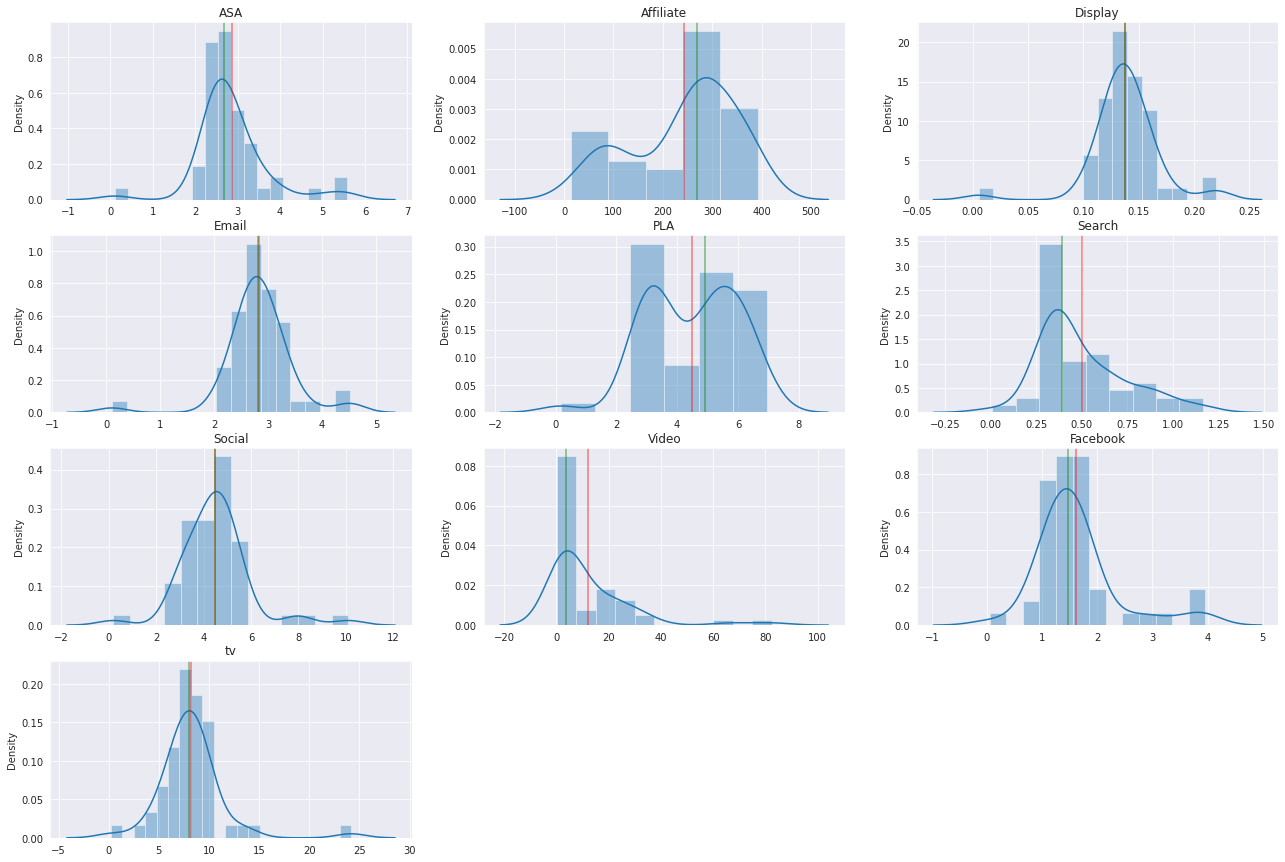

In [32]:
# Calculate overall ROAS and weekly ROAS
# - Overall ROAS = total contribution / total spending
# - Weekly ROAS = weekly contribution / weekly spending

# adstocked media spending
ms_df = pd.DataFrame()
for md in list(hill_models.keys()):
    #print("md: ",md)
    hill_model = hill_models[md]
    x = np.array(hill_model['data']['X']) * hill_model['sc']['x']
    ms_df[md+"_spnd"] = x
# ms_df.to_csv('ms_df1.csv', index=False)

roas_1y = funcs.calc_roas(mc_df, ms_df, period=52)
weekly_roas = funcs.calc_weekly_roas(mc_df, ms_df)
roas1y_df = pd.DataFrame(index=weekly_roas.columns.tolist())
roas1y_df['roas_mean'] = weekly_roas[-52:].apply(np.mean, axis=0)
roas1y_df['roas_median'] = weekly_roas[-52:].apply(np.median, axis=0)


# # plot weekly ROAS distribution
# # median: green line, mean: red line
# f = plt.figure(figsize=(18,12))
# for i in range(len(weekly_roas.columns)):
#     md = weekly_roas.columns[i]
#     ax = f.add_subplot(4,3,i+1)
#     x = weekly_roas[md]
#     mean_x = np.mean(x)
#     median_x = np.median(x)
#     ax = sns.distplot(x)
#     ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
#     ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
#     ax.set(xlabel=None)
#     ax.set_title(md)

# plot weekly ROAS distribution of past 1 year
# median: green line, mean: red line
f = plt.figure(figsize=(22,15))
for i in range(len(weekly_roas.columns)):
    md = weekly_roas.columns[i]
    ax = f.add_subplot(4,3,i+1)
    x = weekly_roas[md][-52:]
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set(xlabel=None)
    ax.set_title(md)


# Calculate mROAS
# 1. Current spending level (cur_sp) is represented by mean or median of weekly spending.    
# Next spending level (next_sp) is increasing cur_sp by 1%.
# 2. Plug cur_sp and next_sp into the Hill function:    
# Current media contribution: cur_mc = Hill(cur_sp)    
# Next-level media contribution next_mc = Hill(next_sp)    
# 3. mROAS = (next_mc - cur_mc) / (0.01 * cur_sp)


# calc mROAS of recent 1 year
mroas_1y = {}
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    mroas_1y[md] = funcs.calc_mroas(hill_model, hill_model_params, period=52)

roas1y_df = pd.concat([
    roas1y_df[['roas_mean', 'roas_median']],
    pd.DataFrame.from_dict(mroas_1y, orient='index', columns=['mroas']),
    pd.DataFrame.from_dict(roas_1y, orient='index', columns=['roas_avg'])
], axis=1)
# roas1y_df.to_csv('roas1y_df1.csv')

roas1y_df
# **ROAS & mROAS**    
# 'roas_avg': overall ROAS = total contribution / total spending    
# 'roas_mean': mean of weekly ROAS    
# 'roas_median': median of weekly ROAS    
# 'mroas': mROAS calculated based on increasing current spending level by 1%   